In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

%matplotlib inline

In [93]:
jigsaw_df = pd.read_csv('../data/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')

In [3]:
jigsaw_df.info(null_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 46 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1999516 non-null  int64  
 1   comment_text                         1999515 non-null  object 
 2   split                                1999516 non-null  object 
 3   created_date                         1999516 non-null  object 
 4   publication_id                       1999516 non-null  int64  
 5   parent_id                            1134709 non-null  float64
 6   article_id                           1999516 non-null  int64  
 7   rating                               1999516 non-null  object 
 8   funny                                1999516 non-null  int64  
 9   wow                                  1999516 non-null  int64  
 10  sad                                  1999516 non-null  int64  
 11

In [32]:
rating_columns = ['rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 
                  'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 
                  'identity_attack', 'insult', 'threat']
jigsaw_df[rating_columns].describe()

,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat
count,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000,1999516.000
mean,0.278,0.044,0.109,2.441,0.581,0.103,0.005,0.014,0.007,0.023,0.081,0.009
std,1.055,0.246,0.456,4.713,1.854,0.197,0.023,0.065,0.045,0.079,0.176,0.049
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,3.000,0.000,0.167,0.000,0.000,0.000,0.000,0.085,0.000
max,102.000,21.000,31.000,300.000,187.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [64]:
col_names = ['severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']
for col in col_names:
    crit = (jigsaw_df[col] > 0) & (jigsaw_df['toxicity'] == 0)
    print(f"Number rated '{col}' but not rated toxic: {sum(crit)}")

Number rated 'severe_toxicity' but not rated toxic: 0
Number rated 'obscene' but not rated toxic: 3349
Number rated 'sexual_explicit' but not rated toxic: 3966
Number rated 'identity_attack' but not rated toxic: 9453
Number rated 'insult' but not rated toxic: 9005
Number rated 'threat' but not rated toxic: 4864


This suggests that we need to look at the other categories and decide whether to include those types of statements in our target as well.

In [107]:
def inspect_ratings(col_name, thresh_list=[0, 0.25, 0.50, 0.75, 0.99]):
    g = sns.histplot(x=jigsaw_df[col_name], bins=20)
    plt.ticklabel_format(style='plain', axis='y');

    for thresh in thresh_list:
        crit = jigsaw_df[col_name] >= thresh
        print(f"{col_name} rating {thresh} \n{len(jigsaw_df[crit])} comments above this threshold")
        for example in range(0,2):
            print(f"Example {example+1}: ", 
                  jigsaw_df[crit].sort_values(by=[col_name])['comment_text'].iloc[example:example+1].values)
        print("\n\n\n")
    return g


toxicity rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ["Give people time to experience the new carbon tax and they'll have a chance to find out whether or not it make a significant difference to climate change. If it does, then it's a good thing because climate control is something we are not able to do yet. Lets assume it does work. Does that mean that climate will be yet another issue the political parties have to include in their electoral platforms. Will Liberals be for more radical changes than Conservatives and will the NDP tie climate to their socialist agenda, the Green Party a climate that increases the growing season and expands the polar ice pack and the Bloc, a climate that emphasizes Quebec's differences? Politics could beco

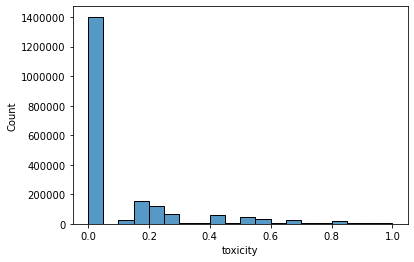

In [108]:
g = inspect_ratings('toxicity')

**Threshold of 0.50** seems appropriate for `toxicity`, to detect comments that are generally considered toxic.

severe_toxicity rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ['Religion of any type does not belong in public schools . With regard to Islam , in Britain it has devolved to the point where Muslim children are allowed to leave school on Friday to attend the neighbourhood mosque.\nHeed the old saying " To see Canada in 20 years , look to Britain today ".']




severe_toxicity rating 0.01 
115525 comments above this threshold
Example 1:  ['If rural residents want what the liberals offer, then perhaps they should vote for democrats in greater numbers. But nope - they keep voting for republicans while their quality of life continues to plummet and their youth move to the cities where jobs are more plentiful, and yet keep putting the blame on 

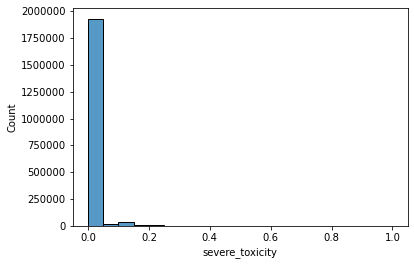

In [109]:
g = inspect_ratings('severe_toxicity', [0, 0.01, 0.10, 0.25, 0.50])

**Threshold of 0.10** seems appropriate for `severe_toxicity`. 

I might want to add this threshold for `severe_toxicity` *in addition* to the criterion for `toxicity`. This will help me make sure not to miss comments that single individuals might consider extremely toxic, even if there isn't a general consensus that the comment might be toxic.

obscene rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ["Thanks for the fairytale chicken little. We all heard that same line of nonsenses before Colorado, Washington, and Oregon legalized it. I hate to break it to you, but the sky didn't fall. In fact, the laws have been a smashing success."]




obscene rating 0.01 
162625 comments above this threshold
Example 1:  ['They all deserve to die, too bad we can stone them in town square.']
Example 2:  ['The US Dept. of Energy has an obligation to retrieve this balloon and the synthetic line from the ocean.  We already have enough plastic dumped into our oceans.  Numerous birds and turtles are being choked by plastic- and whales are ensnared by ropes.\n\nDr. Ernest Moniz is the Sec. of Energy- 

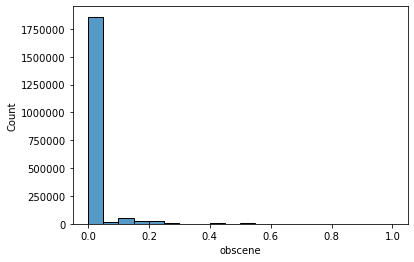

In [110]:
g = inspect_ratings('obscene', [0, 0.01, 0.10, 0.25, 0.50])

I want to add a threshold for `obscene` ratings greater than or equal to 0.25, just to ensure that this type of comment doesn't slip through the gaps.

sexual_explicit rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ["Thank you for this article, Mr. Wohlforth, and God bless you for your service, Mr. Ellis. I'm forwarding this article to my sister, Sandra Wicks -- your former teacher at Bartlett, I believe -- who is currently in Mexico and otherwise might miss it."]




sexual_explicit rating 0.01 
75559 comments above this threshold
Example 1:  ['The whole article is a rant against "white people" who don\'t "recognize" they are the scum of the earth, and need to grovel in apology for it, or else be labelled racists.']
Example 2:  ['What these femanazis fail to realize is that President Trump has hired and cut paychecks to more women blacks latinos gays lesbians transgenders and muslims tha

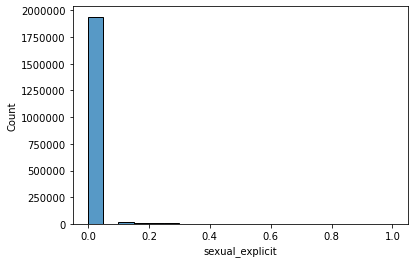

In [111]:
g = inspect_ratings('sexual_explicit', [0, 0.01, 0.10, 0.25, 0.50])

I want to add a threshold for `sexual_explicit` ratings greater than or equal to 0.25, just to ensure that this type of comment doesn't slip through the gaps.

identity_attack rating 0 
1999516 comments above this threshold
Example 1:  ["He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed."]
Example 2:  ["Spoken like a true Liberal shill...Morneau is in over his head in this job and it shows badly  A proper vetting process would've disqualified him from finance  but to Trudeau its more stylish to put some Bay Street flunky into the job to give the appearance of competence."]




identity_attack rating 0.01 
240942 comments above this threshold
Example 1:  ["I think the anger from the right-wing is overstated and besides it may not translate to votes for the Conservatives as they are clearly part of the establishment.\n\nIn any case it's pure speculation to assume what happened in the U.S. could happen here. We are nothing like what they are."]
Example 2:  ['What an infantile, whiny, little megalomaniac.']





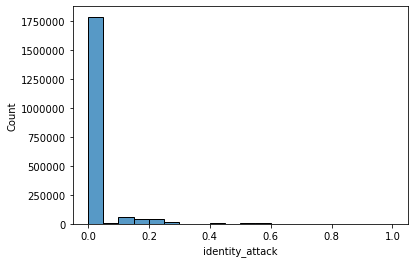

In [112]:
g = inspect_ratings('identity_attack', [0, 0.01, 0.10, 0.25, 0.50])

I want to add a threshold for `identity_attack` ratings greater than or equal to 0.25, just to ensure that this type of comment doesn't slip through the gaps.

insult rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ['" Let countries make their own choices". Who makes the choices - the people or the Presidents for Life.   Not that it would make much difference.  The continent is a basket case of incompetence and corruption.']




insult rating 0.01 
502900 comments above this threshold
Example 1:  ['The only thing worse than a sales tax in Oregon is a regressive sales tax with no exemptions for food, medicine, or the other necessities of life needed  by the poor and those on fixed incomes.']
Example 2:  ['Glaciers are advancing in Chile & Argentina. Time for the climate scientits to dig a little deeper, since they don\'t "get it" yet.']




insult rating 0.1 
499008 comments above this threshold
Ex

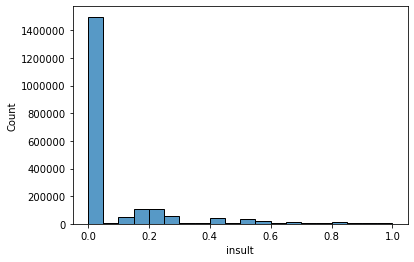

In [113]:
g = inspect_ratings('insult', [0, 0.01, 0.10, 0.25, 0.50])

I want to add a threshold for `insult` ratings greater than or equal to 0.25, just to ensure that this type of comment doesn't slip through the gaps.

threat rating 0 
1999516 comments above this threshold
Example 1:  ['This is NOT a nation of just one ethnicity.  The U.S. Constitution protects all of different ethnicity and race.  The old Kingdom even had peoples of different ethnicity and race as citizens, so why racial separatism now?']
Example 2:  ['Actually, I do.  That remark, in context, was perfectly logical.\n\nYours, however, is not.  Trid is correct.']




threat rating 0.01 
117538 comments above this threshold
Example 1:  ['The whole article is a rant against "white people" who don\'t "recognize" they are the scum of the earth, and need to grovel in apology for it, or else be labelled racists.']
Example 2:  ['a_r:  President Obama had 8 years to fulfill his campaign promise to get out of Afghanistan.  Instead he expanded the war into Syria.']




threat rating 0.1 
91811 comments above this threshold
Example 1:  ['I do agree but anything from CNN. Fox CBS, nbc abc \nNope narrative is Putin annexed violated all internatio

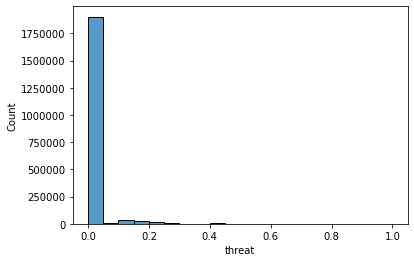

In [114]:
g = inspect_ratings('threat', [0, 0.01, 0.10, 0.25, 0.50])

Personally, I felt like the `threat` ratings were less sensitive to the type of verbiage that might feel threatening to children and vulnerable groups. I will threshold these ratings at 0.1, to include more examples of this type of comment.

In [88]:
is_toxic = (jigsaw_df['toxicity'] >= 0.5) | (jigsaw_df['severe_toxicity'] >= 0.1) | \
            (jigsaw_df['obscene'] >= 0.25) | (jigsaw_df['sexual_explicit'] >= 0.25) | \
            (jigsaw_df['identity_attack'] >= 0.25) | (jigsaw_df['insult'] >= 0.25) | \
            (jigsaw_df['threat'] >= 0.10)

In [89]:
new_target_df = pd.DataFrame()
new_target_df[['id', 'comment_text']] = jigsaw_df[['id', 'comment_text']].copy()
new_target_df['target'] = (is_toxic).astype(int)
new_target_df.info(null_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   id            1999516 non-null  int64 
 1   comment_text  1999515 non-null  object
 2   target        1999516 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


Proportion of comments with 'toxicity' greater than 0.5: 		0.0799 
Proportion of comments exceeding thresholds for multiple criteria: 	0.1692


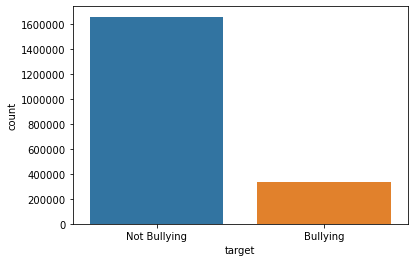

In [116]:
print(f"Proportion of comments with 'toxicity' greater than 0.5: \t\t{(jigsaw_df['toxicity'] >= 0.5).mean():.4f}",
      f"\nProportion of comments exceeding thresholds for multiple criteria: \t{is_toxic.mean():.4f}")

### Make a graph of the class imbalance
g = sns.countplot(x=new_target_df['target'])
g.set_xticklabels(['Not Bullying', 'Bullying'])
plt.ticklabel_format(style='plain', axis='y');

In [90]:
del jigsaw_df